In [190]:
!pip install datasets

In [191]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from scipy.special import softmax
import re
from google.colab import drive

In [192]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [236]:
data = pd.read_csv('/content/drive/My Drive/train.csv')

In [237]:
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [239]:
data = data.drop(["id", "keyword", "location"], axis=1, inplace=False)
data = data.dropna()

In [241]:
print(data["target"].value_counts())

target
0    4342
1    3271
Name: count, dtype: int64


In [197]:
# preprocess samain

def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

data["text"] = data["text"].apply(preprocess)

In [207]:
def tokenize(texts, labels, model, max_len=128):
  tokenizer = AutoTokenizer.from_pretrained(model)

  encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=max_len)
  encodings["labels"] = labels
  dataset = Dataset.from_dict(encodings)
  return dataset

In [199]:
data["target"] = data["target"].astype(int)

x = list(data["text"])
y = list(data["target"])

In [210]:
print(len(x))
print(len(y))

7613
7613


In [201]:
def metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

In [230]:
def train(model_name, train_dataset, test_dataset):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_strategy="epoch",
        metric_for_best_model="accuracy"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    return trainer

In [228]:
def compare():
    model = {
        "bert": "bert-base-uncased",
        "roberta": "roberta-base",
        "distilbert": "distilbert-base-uncased",
        "deberta": "microsoft/deberta-base"
    }

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    for model_label, model_name in model.items():
        print(f"\nTraining with {model_label.upper()}...")

        train_dataset = tokenize(x_train, y_train, model_name)
        test_dataset = tokenize(x_test, y_test, model_name)

        trainer = train(model_name, train_dataset, test_dataset)

        results = trainer.evaluate()
        predictions = trainer.predict(test_dataset)
        y_pred = np.argmax(predictions.predictions, axis=1)
        y_true = predictions.label_ids
        report = classification_report(y_true, y_pred, output_dict=True)

        print(report)

        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix: {model_name}")
        plt.show()

        fpr, tpr, thresholds = roc_curve(y_true, predictions.predictions[:, 1])
        auc = roc_auc_score(y_true, predictions.predictions[:, 1])

        plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve: {model_name}")
        plt.legend()
        plt.show()

    return results


Training with BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenized train dataset: 6090
tokenized test dataset: 1523


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.455400,0.394735,0.841103
2,0.329600,0.418467,0.843729
3,0.241500,0.603885,0.795798
4,0.183200,0.701498,0.810243
5,0.139800,0.778728,0.818122


{'0': {'precision': 0.8427095292766934, 'recall': 0.8398169336384439, 'f1-score': 0.8412607449856734, 'support': 874.0}, '1': {'precision': 0.7852760736196319, 'recall': 0.7889060092449923, 'f1-score': 0.787086856264412, 'support': 649.0}, 'accuracy': 0.8181221273801708, 'macro avg': {'precision': 0.8139928014481627, 'recall': 0.8143614714417181, 'f1-score': 0.8141738006250427, 'support': 1523.0}, 'weighted avg': {'precision': 0.8182352595974859, 'recall': 0.8181221273801708, 'f1-score': 0.8181754831471318, 'support': 1523.0}}


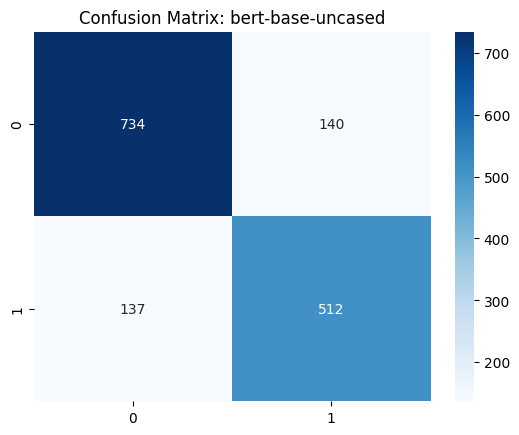

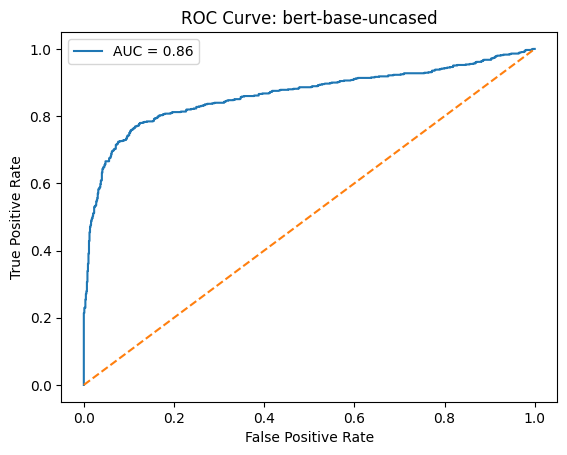


Training with ROBERTA...
tokenized train dataset: 6090
tokenized test dataset: 1523


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.468300,0.385964,0.841103
2,0.362600,0.480635,0.829284
3,0.293800,0.585660,0.818779
4,0.247200,0.519237,0.835850


{'0': {'precision': 0.8354838709677419, 'recall': 0.8890160183066361, 'f1-score': 0.8614190687361419, 'support': 874.0}, '1': {'precision': 0.836424957841484, 'recall': 0.7642526964560863, 'f1-score': 0.7987117552334944, 'support': 649.0}, 'accuracy': 0.8358502954694682, 'macro avg': {'precision': 0.8359544144046129, 'recall': 0.8266343573813613, 'f1-score': 0.8300654119848181, 'support': 1523.0}, 'weighted avg': {'precision': 0.8358848987950949, 'recall': 0.8358502954694682, 'f1-score': 0.8346974361273316, 'support': 1523.0}}


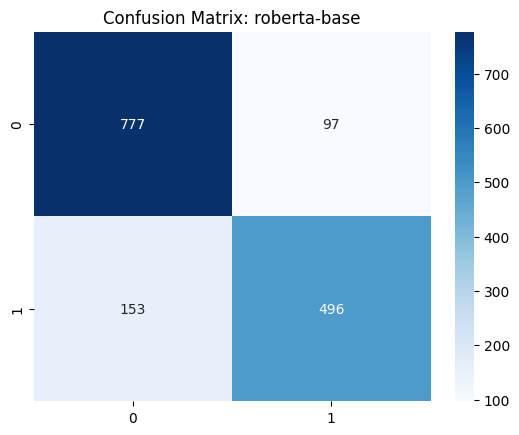

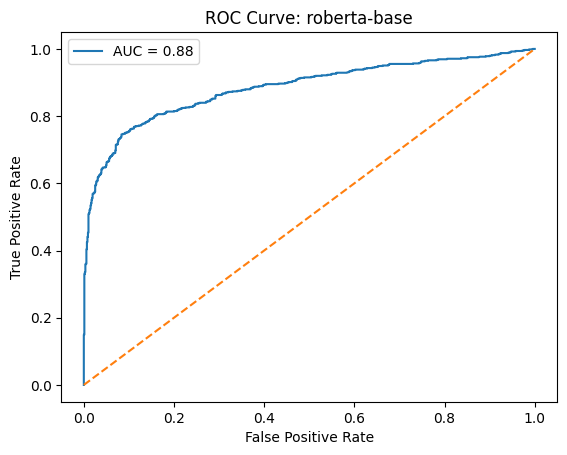


Training with DISTILBERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenized train dataset: 6090
tokenized test dataset: 1523


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.441600,0.386202,0.839790
2,0.328400,0.414435,0.845043
3,0.242800,0.525849,0.816152
4,0.179700,0.593313,0.834537
5,0.126800,0.861671,0.786605


{'0': {'precision': 0.8523748395378691, 'recall': 0.7597254004576659, 'f1-score': 0.8033877797943134, 'support': 874.0}, '1': {'precision': 0.717741935483871, 'recall': 0.8228043143297381, 'f1-score': 0.7666905958363245, 'support': 649.0}, 'accuracy': 0.7866053841103086, 'macro avg': {'precision': 0.7850583875108701, 'recall': 0.791264857393702, 'f1-score': 0.7850391878153189, 'support': 1523.0}, 'weighted avg': {'precision': 0.7950033656501181, 'recall': 0.7866053841103086, 'f1-score': 0.7877499121720318, 'support': 1523.0}}


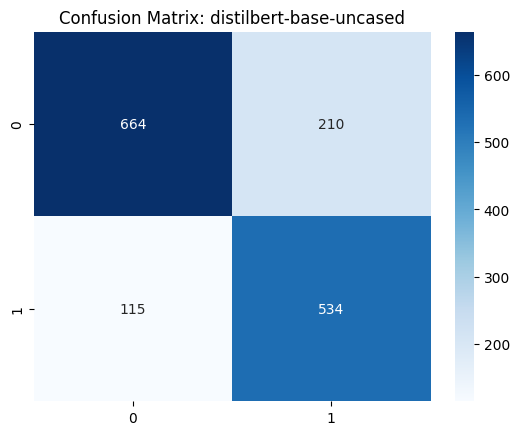

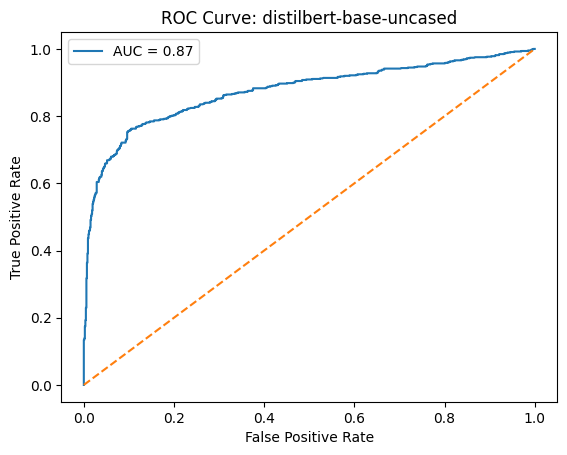


Training with DEBERTA...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenized train dataset: 6090
tokenized test dataset: 1523


pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.464600,0.393325,0.835850
2,0.353200,0.484387,0.829941


Epoch,Training Loss,Validation Loss,Accuracy
1,0.464600,0.393325,0.835850
2,0.353200,0.484387,0.829941
3,0.258500,0.605838,0.810900
4,0.195400,0.638328,0.823375


{'0': {'precision': 0.852975495915986, 'recall': 0.8363844393592678, 'f1-score': 0.8445984979780474, 'support': 874.0}, '1': {'precision': 0.7852852852852853, 'recall': 0.8058551617873652, 'f1-score': 0.7954372623574144, 'support': 649.0}, 'accuracy': 0.8233749179251477, 'macro avg': {'precision': 0.8191303906006356, 'recall': 0.8211198005733165, 'f1-score': 0.8200178801677309, 'support': 1523.0}, 'weighted avg': {'precision': 0.8241304882342232, 'recall': 0.8233749179251477, 'f1-score': 0.823649291203398, 'support': 1523.0}}


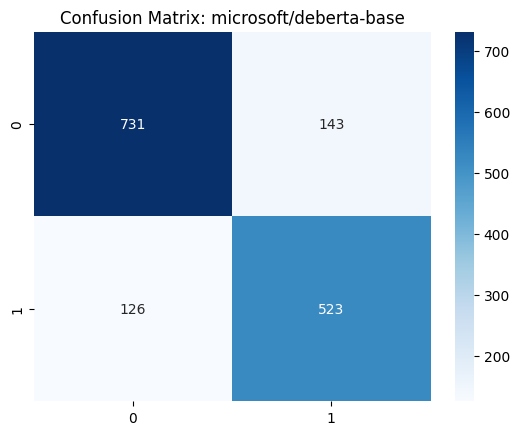

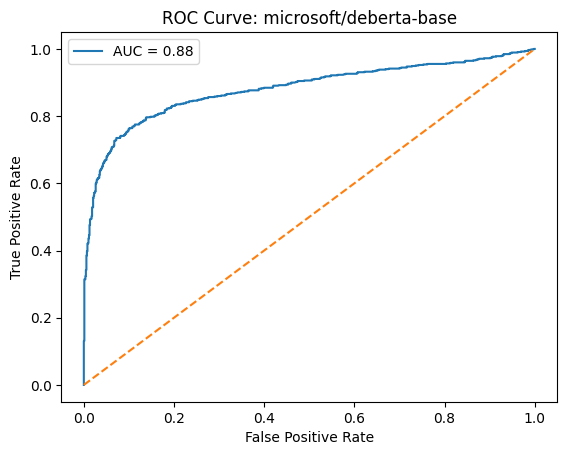

In [231]:
results = compare()